In [5]:
%%capture
!pip install sagemaker==1.72.0

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import boto3
import sagemaker
import ast
import json
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator
from sagemaker.sklearn.estimator import SKLearn

In [7]:
import source.load
from source.load import *
from source import create

data_dict = source.load.load_data()
data = data_dict['data']
symbols = data_dict['symbols']

<h2> XGBoost </h2>

In [8]:
class xgboost:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.train_loc = os.path.join(DATA_DIR, 'train.csv')
        self.val_loc = os.path.join(DATA_DIR, 'val.csv')
        
        self.hyperparams = hyperparams
        
        self.model = None
        self.predictor = None
    
    
    def __del__(self):
        self.cleanup()
        
        
    def fit(self):
        pd.concat([self.sets['train']['Y'], self.sets['train']['X']], axis=1) \
                        .to_csv(self.train_loc, header=False, index=False)
        pd.concat([self.sets['val']['Y'], self.sets['val']['X']], axis=1) \
                        .to_csv(self.val_loc, header=False, index=False)

        train_location = self.session.upload_data(self.train_loc, key_prefix=self.prefix)
        val_location = self.session.upload_data(self.val_loc, key_prefix=self.prefix)

        train_input = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
        val_input = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

        container = get_image_uri(self.session.boto_region_name, 'xgboost')

        estimator = Estimator(container,
                              self.role, 
                              train_instance_count=1,
                              train_instance_type='ml.m4.xlarge',
                              output_path='s3://{}/{}/output'.format(self.bucket, self.prefix),
                              sagemaker_session=self.session)

        estimator.set_hyperparameters(**self.hyperparams)

        estimator.fit({'train': train_input, 'validation': val_input})
        
        self.model = estimator
    
    
    def init_predictor(self):
        self.predictor = self.model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
        self.predictor.content_type = 'text/csv'
        self.predictor.serializer = csv_serializer
        
        return self.predictor

    
    def predict(self, predict_set, unscaled=True, batch_size=250):
        X_val = self.sets[predict_set]['X'].values
        
        n_batch = int(round(len(X_val)/batch_size, -1))

        pred_Y = [self.predictor.predict(batch).decode('utf-8') for batch in np.array_split(X_val, n_batch)]
        pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
        pred_Y = np.array([val for sublist in pred_Y for val in sublist])
        
        if unscaled:
            base = self.sets[predict_set]['ori'].copy()
            pred_mean = base[self.target+'_mean']
            pred_std = base[self.target+'_std']
            pred = (pred_Y * pred_std) + pred_mean
        else:
            base = self.sets[predict_set]['scaled'].copy()
            pred = pred_Y
    
        base['pred'] = pred
        base = base.set_index('time')

        return base
    
    
    def cleanup(self):
        self.predictor.delete_endpoint()
        os.remove(self.train_loc)
        os.remove(self.val_loc)

In [9]:
!pygmentize source/xgboost.py

import numpy as np
import pandas as pd
import boto3
import ast
import json
import os

import pkg_resources
pkg_resources.require("sagemaker==1.72.0")
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator
from sagemaker.sklearn.estimator import SKLearn

from source.load import DATA_DIR
from source import create

class xgboost:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.train_loc = os.path.join(DATA_DIR, 'train.csv')
        self.val_loc = os.path.join(DATA_DIR, 'val.csv')
        
        self.hyperparams = hyperparams


In [10]:
from source import xgboost

hyperparams = {'max_depth':10,
               'eta':0.1,
               'gamma':0.2,
               'min_child_weight':15,
               'subsample':0.8,
               'objective':'reg:linear',
               'early_stopping_rounds':20,
               'num_round':300,
               'seed':100}
               
xgb = xgboost(prefix='xgboost',
              data=data,
              W=5,
              target='price',
              hyperparams=hyperparams)

In [11]:
xgb.fit()

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-02-06 03:18:37 Starting - Starting the training job...
2021-02-06 03:18:39 Starting - Launching requested ML instances......
2021-02-06 03:19:42 Starting - Preparing the instances for training...
2021-02-06 03:20:37 Downloading - Downloading input data......
2021-02-06 03:21:30 Training - Training image download completed. Training in progress..Arguments: train
[2021-02-06:03:21:31:INFO] Running standalone xgboost training.
[2021-02-06:03:21:31:INFO] File size need to be processed in the node: 24.96mb. Available memory size in the node: 8436.94mb
[2021-02-06:03:21:31:INFO] Determined delimiter of CSV input is ','
[03:21:31] S3DistributionType set as FullyReplicated
[03:21:31] 25862x35 matrix with 905170 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-06:03:21:31:INFO] Determined delimiter of CSV input is ','
[03:21:31] S3DistributionType set as FullyReplicated
[03:21:31] 13849x35 matrix with 484715 entries loaded from /opt/ml/input/data/

In [12]:
xgb.init_predictor()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [42]:
xgb_test = xgb.predict('test', unscaled=True)
xgb_val = xgb.predict('val', unscaled=True)
xgb_train = xgb.sets['train']['ori']
xgb_train.set_index('time', drop=True, inplace=True)

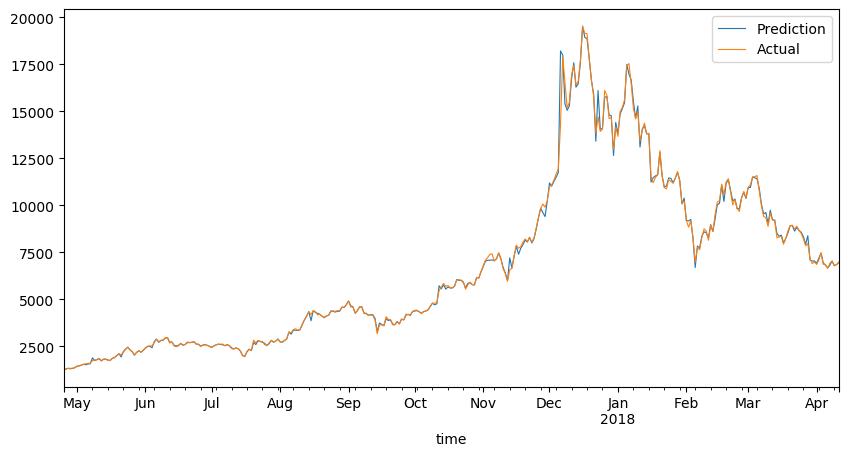

In [43]:
result = xgb_test
sym='BTC'
plt.figure(figsize=(10,5), dpi=100)

result[result['sym'] == sym]['pred'].plot(label='Prediction', lw=0.8)
result[result['sym'] == sym]['price'].plot(label='Actual', lw=0.8)

plt.legend()
plt.show()

In [44]:
xgb.cleanup()

<h2> Neural Network </h2>

In [3]:
class neuralnet:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.train_loc = os.path.join(DATA_DIR, 'train.csv')
        self.val_loc = os.path.join(DATA_DIR, 'val.csv')
        
        self.hyperparams = hyperparams
        
        self.model = None
        self.predictor = None
    
    
    def __del__(self):
        self.cleanup()
        
        
    def fit(self):
        pd.concat([self.sets['train']['Y'], self.sets['train']['X']], axis=1) \
                    .to_csv(self.train_loc, header=False, index=False)
        pd.concat([self.sets['val']['Y'], self.sets['val']['X']], axis=1) \
                    .to_csv(self.val_loc, header=False, index=False)

        train_location = self.session.upload_data(self.train_loc, key_prefix=self.prefix)
        val_location = self.session.upload_data(self.val_loc, key_prefix=self.prefix)

        estimator = SKLearn(entry_point='train.py',
                            source_dir='source',
                            role=self.role,
                            train_instance_count=1, 
                            train_instance_type='ml.c4.xlarge',
                            framework_version='0.23-1',
                            py_version='py3',
                            output_path='s3://{}/{}/output'.format(self.bucket, prefix),
                            sagemaker_session=self.session,
                            hyperparameters=self.hyperparams)

        estimator.fit({'train': train_location, 'validation':val_location})
        
        self.model = estimator
    
    
    def init_predictor(self):
        self.predictor = self.model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
        self.predictor.content_type = 'text/csv'
        self.predictor.serializer = csv_serializer
        
        return self.predictor

    
    def predict(self, predict_set, unscaled=True, batch_size=250):
        X_val = self.sets[predict_set]['X'].values
        
        n_batch = int(round(len(X_val)/batch_size, -1))

        pred_Y = [self.predictor.predict(batch) for batch in np.array_split(X_val, 100)]
        pred_Y = np.array([val for sublist in pred_Y for val in sublist])
        
        if unscaled:
            base = self.sets[predict_set]['ori'].copy()
            pred_mean = base[self.target+'_mean']
            pred_std = base[self.target+'_std']
            pred = (pred_Y * pred_std) + pred_mean
        else:
            base = self.sets[predict_set]['scaled'].copy()
            pred = pred_Y
    
        base['pred'] = pred
        base = base.set_index('time')

        return base
    
    
    def cleanup(self):
        self.predictor.delete_endpoint()
        os.remove(self.train_loc)
        os.remove(self.val_loc)
        

In [4]:
!pygmentize source/neuralnet.py

import numpy as np
import pandas as pd
import boto3
import ast
import json
import os

import pkg_resources
pkg_resources.require("sagemaker==1.72.0")
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator
from sagemaker.sklearn.estimator import SKLearn

from source.load import DATA_DIR
from source import create

class neuralnet:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.train_loc = os.path.join(DATA_DIR, 'train.csv')
        self.val_loc = os.path.join(DATA_DIR, 'val.csv')
        
        self.hyperparams = hyperparam

In [5]:
from source import neuralnet

hyperparams = {'hidden_layers': 50,
                'max_iter': 1000}
               
nn = neuralnet(prefix='neuralnet',
               data=data,
               W=5,
               target='price',
               hyperparams=hyperparams)

In [6]:
nn.fit()

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-04 18:17:13 Starting - Starting the training job...
2021-02-04 18:17:16 Starting - Launching requested ML instances......
2021-02-04 18:18:20 Starting - Preparing the instances for training...
2021-02-04 18:19:09 Downloading - Downloading input data......
2021-02-04 18:20:00 Training - Training image download completed. Training in progress.2021-02-04 18:20:00,894 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-02-04 18:20:00,896 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-04 18:20:00,906 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-02-04 18:20:01,367 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-04 18:20:02,793 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-04 18:20:02,805 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-04

In [7]:
nn.init_predictor()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [8]:
result = nn.predict('test', unscaled=False)

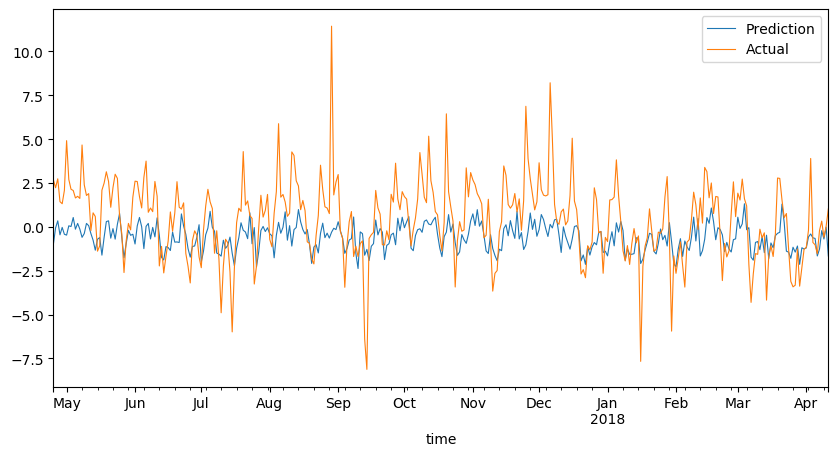

In [10]:
sym='BTC'
plt.figure(figsize=(10,5), dpi=100)

result[result['sym'] == sym]['pred'].plot(label='Prediction', lw=0.8)
result[result['sym'] == sym]['price'].plot(label='Actual', lw=0.8)

plt.legend()
plt.show()

In [11]:
nn.cleanup()

<h2> LSTM (DeepAR) </h2>

In [12]:
class deepar:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.features = self.sets['features']
        self.trainval_loc = os.path.join(DATA_DIR, 'trainval.json')
        
        self.hyperparams = hyperparams
        self.context_length = hyperparams['context_length']
        
        self.model = None
        self.predictor = None
        self.mapping = {}
        self.pred = pd.DataFrame()
    
    
    def __del__(self):
        self.cleanup()


    def write_json_dataset(self, features_df, filename): 
        symbols = features_df['sym'].unique()
        with open(filename, 'wb') as f:

            for idx, sym in enumerate(symbols):
                sym_df = features_df[features_df['sym'] == sym]
                sym_df = sym_df.drop(columns='sym')

                json_obj = {"start": str(sym_df['time'].iloc[0]), 
                            "target": list(sym_df[self.target]), 
                            "cat":[idx], 
                            "dynamic_feat":[list(sym_df[column]) for column in self.features]}

                json_line = json.dumps(json_obj) + '\n'
                json_line = json_line.encode('utf-8')

                f.write(json_line)

                self.mapping[sym] = idx
        print('JSON file created at ' + filename)
        
        
    def fit(self):
        self.write_json_dataset(self.sets['trainval']['scaled'], self.trainval_loc)

        trainval_location = self.session.upload_data(self.trainval_loc, key_prefix=self.prefix)

        container = get_image_uri(self.session.boto_region_name,'forecasting-deepar')

        estimator = Estimator(container,
                              role=self.role,   
                              train_instance_count=1, 
                              train_instance_type='ml.m4.xlarge', 
                              output_path='s3://{}/{}/output'.format(self.bucket, self.prefix),
                              sagemaker_session=self.session)


        estimator.set_hyperparameters(**self.hyperparams)

        estimator.fit({'train': trainval_location})
        
        self.model = estimator
    
    
    def init_predictor(self):
        self.predictor = self.model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
        
        return self.predictor
    
    
    def json_predictor_input(self, features_df, date, num_samples=50):
        instances = []
        symbols = features_df['sym'].unique()
        look_back_date = date - pd.Timedelta(self.context_length, 'D')
        window = features_df.query("time >= @look_back_date & time <= @date")

        for sym in symbols:
            idx = self.mapping[sym]
            sym_window = window.query("sym == @sym")

            if sym_window.empty:
                continue

            json_obj = {"start": str(list(sym_window['time'])[0]), 
                        "target": list(sym_window[self.target])[:-1],
                        "cat":[idx], 
                        "dynamic_feat":[list(sym_window[column]) for column in self.features]}
            instances.append(json_obj)

        configuration = {"num_samples": num_samples, 
                         "output_types": ["mean"]}

        request_data = {"instances": instances, 
                        "configuration": configuration}

        json_request = json.dumps(request_data).encode('utf-8')

        return json_request

    
    def decode_prediction(self, prediction, encoding='utf-8'):
        '''Accepts a JSON prediction and returns a list of prediction data.
        '''
        prediction_data = json.loads(prediction.decode(encoding))
        prediction_list = []
        
        for k in range(len(prediction_data['predictions'])):
            prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['mean']))
        
        return prediction_list

    
    def loop_predict(self, features_df, start, end):
        dates = list(set(features_df[(features_df.time >= start) & (features_df.time <= end)]['time']))

        df = pd.DataFrame([])
        for date in dates:
            test_features = self.json_predictor_input(features_df, date)
            json_prediction = self.predictor.predict(test_features)
            pred = [float(x.values.squeeze()) for x in self.decode_prediction(json_prediction)]
            temp_df = pd.DataFrame(zip([sym for sym in features_df['sym'].unique()], pred), 
                                   columns=['sym', 'pred'])
            temp_df['time'] = date

            df = df.append(temp_df, ignore_index=True)

        return df

    
    def predict(self, predict_set, unscaled=True, recalculate=True):
        trainval = self.sets['trainval']['scaled']
        test = self.sets['test']['scaled']
        X_val = pd.concat([trainval, test], axis=0)
        
        if predict_set == 'test':
            start = TEST_START
            end = X_val.time.max()
        elif predict_set == 'val':
            start = VAL_START
            end = TEST_START - pd.Timedelta(1, 'D')
        else:
            start = TRAIN_START - pd.Timedelta(self.context_length, 'D')
            end = TRAIN_END
            
        if self.pred.empty or recalculate:
            self.pred = self.loop_predict(X_val, start, end)
            
        pred_Y = self.pred
            
        if unscaled:
            base = self.sets[predict_set]['ori'].copy()
            base = pd.merge(base, pred_Y, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])
            pred_mean = base[self.target+'_mean'].reset_index(drop=True)
            pred_std = base[self.target+'_std'].reset_index(drop=True)
            base['pred'] = (base['pred'] * pred_std) + pred_mean
        else:
            base = self.sets[predict_set]['scaled'].copy()
            base = pd.merge(base, pred_Y, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])
            
        base = base.set_index('time')

        return base
    
    
    def cleanup(self):
        self.predictor.delete_endpoint()
        os.remove(self.trainval_loc)

In [13]:
!pygmentize source/deepar.py

import numpy as np
import pandas as pd
import boto3
import ast
import json
import os

import pkg_resources
pkg_resources.require("sagemaker==1.72.0")
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator
from sagemaker.sklearn.estimator import SKLearn

from source.load import DATA_DIR
from source import create

class deepar:
    
    def __init__(self, prefix, data, W, target, hyperparams):
        self.session = sagemaker.Session()
        self.role = get_execution_role()
        self.bucket = self.session.default_bucket()
        self.prefix = prefix
        
        self.W = W
        self.target = target
        self.sets = create.load_sets(data, self.target, self.W)
        self.features = self.sets['features']
        self.trainval_loc = os.path.join(DATA_DIR, 'trainval.json')
        
        self.hyperparams = hyperparams
     

In [16]:
from source import deepar

hyperparams = {
    "epochs": "1",
    "time_freq": 'D',
    "prediction_length": '1',
    "context_length": '50',
    "num_cells": "100",
    "num_layers": "4",
    "mini_batch_size": "128",
    "learning_rate": "0.1",
    "early_stopping_patience": "20"
}

lstm = deepar(prefix='deepar',
              data=data,
              W=5,
              target='price',
              hyperparams=hyperparams)

In [17]:
lstm.fit()

JSON file created at ./data/trainval.json


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-04 18:29:54 Starting - Starting the training job...
2021-02-04 18:29:55 Starting - Launching requested ML instances......
2021-02-04 18:31:01 Starting - Preparing the instances for training......
2021-02-04 18:31:56 Downloading - Downloading input data...
2021-02-04 18:32:42 Training - Downloading the training image..Arguments: train
[02/04/2021 18:33:05 INFO 140036922447680] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[02/04/2021 18:33:0

In [18]:
lstm.init_predictor()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [19]:
result = lstm.predict('test', unscaled=False)

NameError: name 'TEST_START' is not defined

In [ ]:
sym='BTC'
plt.figure(figsize=(10,5), dpi=100)

result[result['sym'] == sym]['pred'].plot(label='Prediction', lw=0.8)
result[result['sym'] == sym]['price'].plot(label='Actual', lw=0.8)

plt.legend()
plt.show()

In [ ]:
lstm.cleanup()

<h2> Plotting Routines </h2>

In [23]:
def plot_results(array, sym, scale='linear', figsize=(10,5), dpi=100):
    plt.figure(figsize=figsize, dpi=dpi)
    
    for key in array:
        array[key].query('sym == @sym')['price'].plot(label=key, lw=0.8)
        try:
            array[key].query('sym == @sym')['pred'].plot(label=key+' Prediction', lw=0.8)
        except:
            pass
    
    plt.yscale(scale)
    plt.legend()
    plt.show()

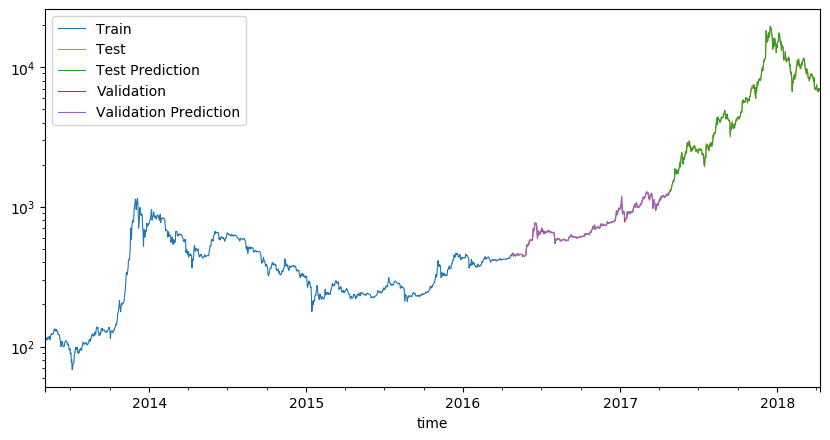

In [31]:
plot_results({'Train': xgb_train, 'Test': xgb_test, 'Validation': xgb_val}, scale='log', sym='BTC')

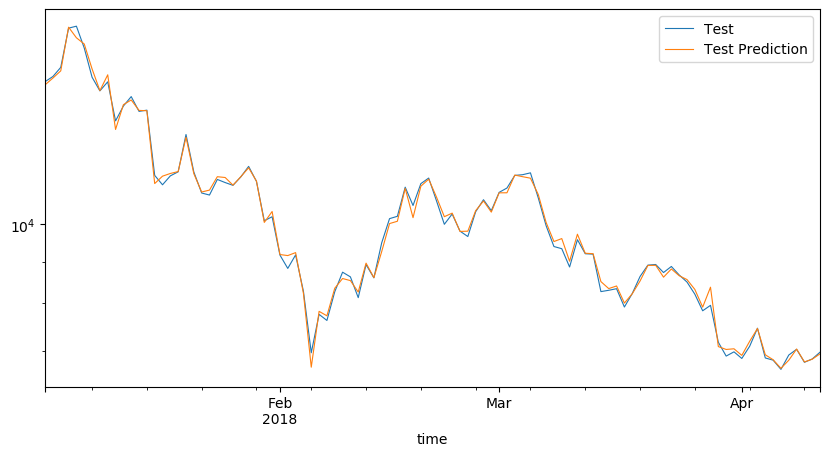

In [41]:
plot_results({'Test': xgb_test.query('time > "2018-01-01"')}, scale='log', sym='BTC')